In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyzx as zx
import quizx
import time
import random
from tqdm import trange
%matplotlib inline

In [2]:
import os
from typing import Tuple, List, Union, Dict, Iterable
from pyzx.rank_width import adjacency_matrix, generate_decomposition, tensorfy_rw_subtree
from pyzx.linalg import rank_factorise

class capture_fd_stdout:
    """
    Context manager that captures ALL writes to the process's stdout (fd=1),
    including from Rust/C extensions using printf/println!.
    """

    def __enter__(self):
        self._saved_fd = os.dup(1)  # duplicate stdout fd
        self._r, self._w = os.pipe()  # create pipe
        os.dup2(self._w, 1)  # redirect fd=1 to pipe writer
        os.close(self._w)  # close our duplicate writer
        return self

    def __exit__(self, exc_type, exc, tb):
        os.dup2(self._saved_fd, 1)  # restore stdout
        os.close(self._saved_fd)  # close saved copy

    def read(self) -> str:
        # Read all data from the pipe reader
        chunks = []
        # Set non-blocking read in case nothing is there
        import fcntl
        flags = fcntl.fcntl(self._r, fcntl.F_GETFL)
        fcntl.fcntl(self._r, fcntl.F_SETFL, flags | os.O_NONBLOCK)
        try:
            while True:
                try:
                    data = os.read(self._r, 65536)
                    if not data:
                        break
                    chunks.append(data)
                except BlockingIOError:
                    break
        finally:
            os.close(self._r)
        return b"".join(chunks).decode(errors="replace")


def simplify_get_pivots(g: quizx.VecGraph):
    sys.stdout.flush()
    with capture_fd_stdout() as cap:
        quizx.full_simp(g)
    pivots = [tuple(map(int, l.split())) for l in cap.read().splitlines() if l.strip()]
    return pivots


def phase_gadgets(g: zx.graph.base.BaseGraph):
    gadgets = []
    for v in g.vertices():
        if g.vertex_degree(v) != 1:
            continue
        u = list(g.neighbors(v))[0]
        if v in g.inputs() or v in g.outputs() or g.phase(u) != 0:
            continue
        gadgets.append((v, u))
    return gadgets


def causal_flow(g: zx.graph.base.BaseGraph) -> Union[Tuple[Dict[int, int], Dict[int, int]], None]:
    """
    Compute the causal flow of a ZX diagram if it exists
    :param g: BaseGraph - ZX diagram
    :return labels: dict[int, int] - partial order
            nxt: dict[int, int] - correction function
    """
    l = dict()
    nxt = dict()
    V = set(g.vertices())
    In = set(g.inputs())
    Inc = V - In
    Out = set(g.outputs())
    Outc = V - Out
    C = set(g.outputs())
    k = 1
    while True:
        Out1 = set()
        C1 = set()
        for v in C:
            nb = set(g.neighbors(v)) & Outc
            if len(nb) == 1:
                u = list(nb)[0]
                nxt[u] = v
                l[v] = k
                Out1 |= {u}
                C1 |= {v}
        if not Out1:
            if Out == V:
                for v in In:
                    l[v] = k
                return l, nxt
            return None
        Out |= Out1
        Outc -= Out1
        C = (C - C1) | (Out1 & Inc)
        k += 1

def flow_order(g: zx.graph.base.BaseGraph, flatten=False) -> Tuple[zx.graph.base.BaseGraph, List]:
    """
    Fast algorithm computing gflow linearisation for ZX diagrams.
    :param g: BaseGraph - ZX diagram
    :param flatten: bool - treat phase gadgets as separate vertices (width +1)
    :return g: BaseGraph - simplified ZX diagram
            order: list - linearised gflow, possibly with pairs corresponding to the phase gadgets
    """
    zx.to_graph_like(g)
    zx.id_simp(g)
    zx.spider_simp(g)
    layers, _ = causal_flow(g)
    init_order = sorted(list(layers.keys()), key=lambda v: layers[v], reverse=True)
    g.apply_state('0' * g.num_inputs())
    g.apply_effect('0' * g.num_outputs())
    with capture_fd_stdout() as _:
        g = g.copy(backend="quizx-vec")
    init_order_dict = {v: i for i, v in enumerate(sorted(init_order))}
    pivots = simplify_get_pivots(g)
    with capture_fd_stdout() as _:
        order = [init_order_dict[v] for v in init_order if init_order_dict[v] in g.vertices()]
        gadgets = phase_gadgets(g)
    for u, v in pivots + gadgets:
        if u not in order or v not in order:
            continue
        order.pop(order.index(v))
        order.insert(order.index(u) + 1, v)
    if not flatten:
        for u, v in gadgets:
            pos = order.index(u)
            if order[pos:pos + 2] != [u, v]:
                continue
            order[pos:pos + 2] = [[u, v]]
    return g, order


def build_linear(arr: Iterable):
    decomp = None
    for elem in arr:
        decomp = elem if decomp is None else [decomp, elem]
    return decomp


def convolution_flops(r_u, r_v, r_w):
    r_max = max(r_u, r_v, r_w)
    if r_max == r_u:
        return 2.0 ** (r_v + r_w) * 3
    elif r_max == r_v:
        return 2.0 ** (r_u + r_w) * (4 + r_w)
    else:
        return 2.0 ** (r_u + r_v) * (4 + r_v)


def decomposition_flops(g, decomp):
    S_0 = set(g.vertices())

    def iterate(elem):
        if isinstance(elem, int):
            return {elem}, 0
        S_v, cost_v = iterate(elem[0])
        S_w, cost_w = iterate(elem[1])
        S_u = S_v | S_w
        r_u = rank_factorise(adjacency_matrix(g, S_u, S_0 - S_u))[0].shape[1]
        r_v = rank_factorise(adjacency_matrix(g, S_v, S_0 - S_v))[0].shape[1]
        r_w = rank_factorise(adjacency_matrix(g, S_w, S_0 - S_w))[0].shape[1]
        return S_u, cost_v + cost_w + convolution_flops(r_u, r_v, r_w)

    if decomp is None:
        return 0
    return int(iterate(decomp)[1])


def tensorfy_decomp(g: zx.graph.base.BaseGraph, decomp):
    if decomp is None:
        return np.array(g.scalar.to_number())
    result, _, _, boundary = tensorfy_rw_subtree(g, decomp)
    result *= g.scalar.to_number()
    order = list(g.outputs()) + list(g.inputs())
    boundary_idx = {v: i for i, v in enumerate(boundary)}
    perm = [boundary_idx[v] for v in order]
    return result.reshape((2,) * len(order), order='F').transpose(perm)


from pyzx.tensor import Z_box_to_tensor, Z_to_tensor, X_to_tensor, H_to_tensor, W_to_tensor, get_z_box_label, pop_and_shift
from math import pi
import itertools


def tensorfy_naive_flops(g, preserve_scalar: bool = True):
    rows = g.rows()
    phases = g.phases()
    types = g.types()
    verts_row = {}
    for v in g.vertices():
        r = rows[v]
        if r in verts_row: verts_row[r].append(v)
        else: verts_row[r] = [v]

    inputs = g.inputs()
    outputs = g.outputs()
    if not inputs and not outputs:
        if any(g.type(v)==zx.VertexType.BOUNDARY for v in g.vertices()):
            raise ValueError("Diagram contains BOUNDARY-type vertices, but has no inputs or outputs set. Perhaps call g.auto_detect_io() first?")

    had = 1/(2**0.5)*np.array([[1,1],[1,-1]])
    id2 = np.identity(2)
    #tensor = np.array(1.0,dtype='complex128')
    qubits = len(inputs)
    tensor_ndim = qubits
    #for i in range(qubits): tensor = np.tensordot(tensor,id2,axes=0)
    inputs = tuple(inputs)
    indices = {}
    for i, v in enumerate(inputs):
        indices[v] = [1 + 2*i]
    
    flops = 0

    for i,r in enumerate(sorted(verts_row.keys())):
        for v in sorted(verts_row[r]):
            if types[v] == zx.VertexType.DUMMY:
                continue
            neigh = list(itertools.chain.from_iterable(
                set(g.edge_st(e)) - {v} for e in g.incident_edges(v)
            ))
            self_loops = [e for e in g.incident_edges(v) if g.edge_s(e) == g.edge_t(e)]
            d = len(neigh) + len(self_loops) * 2
            if v in inputs:
                if types[v] != zx.VertexType.BOUNDARY: raise ValueError("Wrong type for input:", v, types[v])
                continue # inputs already taken care of
            if v in outputs:
                if d != 1: raise ValueError("Weird output")
                if types[v] != zx.VertexType.BOUNDARY: raise ValueError("Wrong type for output:",v, types[v])
                d += 1
                t = id2
            else:
                p = phases[v]
                phase = pi*p
                if types[v] == zx.VertexType.Z:
                    t = Z_to_tensor(d,phase)
                elif types[v] == zx.VertexType.X:
                    t = X_to_tensor(d,phase)
                elif types[v] == zx.VertexType.H_BOX:
                    t = H_to_tensor(d,phase)
                elif types[v] == zx.VertexType.W_INPUT or types[v] == zx.VertexType.W_OUTPUT:
                    if phase != 0: raise ValueError("Phase on W node")
                    t = W_to_tensor(d)
                elif types[v] == zx.VertexType.Z_BOX:
                    if phase != 0: raise ValueError("Phase on Z box")
                    label = get_z_box_label(g, v)
                    t = Z_box_to_tensor(d, label)
                else:
                    raise ValueError("Vertex %s has non-ZXH type but is not an input or output" % str(v))
            for sl in self_loops:
                if g.edge_type(sl) == zx.EdgeType.HADAMARD:
                    t = np.tensordot(t,had)
                elif g.edge_type(sl) == zx.EdgeType.SIMPLE:
                    t = np.trace(t)
                else:
                    raise NotImplementedError(f"Tensor contraction with {repr(sl)} self-loops is not implemented.")
            nn = list(filter(lambda n: rows[n]<r or (rows[n]==r and n<v), neigh)) # TODO: allow ordering on vertex indices?
            ety = {n:g.edge_type(g.edge(v,n)) for n in nn}
            nn.sort(key=lambda n: ety[n])
            for n in nn:
                if ety[n] == zx.EdgeType.HADAMARD:
                    t = np.tensordot(t,had,(0,0)) # Hadamard edges are moved to the last index of t
            contr = pop_and_shift(nn,indices) #the last indices in contr correspond to hadamard contractions
            # tensor = np.tensordot(tensor,t,axes=(contr,list(range(len(t.shape)-len(contr),len(t.shape)))))
            tensor_ndim += t.ndim - 2 * len(contr)
            flops += 2 ** (tensor_ndim + len(contr))
            indices[v] = list(range(tensor_ndim-d+len(contr), tensor_ndim))
    
    return flops

In [3]:
def simulate_graph(g: zx.graph.base.BaseGraph, strategy='naive', flops=False):
    """
    g: ZX graph
    strategy: 'naive', 'rw-greedy-linear', 'rw-greedy-b2t', 'quimb', 'quimb-red', 'stab-decomp'
    flops: return flops instead of simulation result
    """
    g = g.copy()
    if strategy in ['naive', 'rw-greedy-linear', 'rw-greedy-b2t']:
        if not flops:
            return g.to_tensor(strategy=strategy)
        else:
            if strategy == 'naive':
                return tensorfy_naive_flops(g)
            zx.full_reduce(g)
            decomp = generate_decomposition(g, strategy=strategy)
            return decomposition_flops(g, decomp)
    elif strategy == 'quimb':
        tn = zx.to_quimb_tensor(g).full_simplify()
        return tn.contract(output_inds = (), optimize='auto-hq') if not flops else tn.contraction_cost(optimize='auto-hq')
    elif strategy == 'quimb-red':
        zx.full_reduce(g)
        tn = zx.to_quimb_tensor(g).full_simplify()
        return tn.contract(output_inds = (), optimize='auto-hq') if not flops else tn.contraction_cost(optimize='auto-hq')
    elif strategy == 'stab-decomp':
        zx.full_reduce(g)
        with capture_fd_stdout() as _:
            driver = quizx.Decomposer(g.copy(backend='quizx-vec'))
            driver.with_full_simp()
            driver.decompose(driver_type='DynamicT')
        return driver.get_scalar().to_number() if not flops else driver.get_nterms()
    else:
        raise ValueError(f'Unknown simulation strategy {strategy}')

def simulate_circuit(circ: zx.Circuit, strategy='naive', flops=False):
    """
    circ: ZX circuit
    strategy: 'naive', 'rw-flow', 'rw-greedy-linear', 'rw-greedy-b2t', 'quimb', 'quimb-red', 'stab-decomp'
    flops: return flops instead of simulation result
    """
    if strategy == 'rw-flow':
        g, order = flow_order(circ.to_graph())
        decomp = build_linear(order)
        return tensorfy_decomp(g, decomp) if not flops else decomposition_flops(g, decomp)
    g = circ.to_graph()
    g.apply_state('0' * circ.qubits)
    g.apply_effect('0' * circ.qubits)
    return simulate_graph(g, strategy=strategy, flops=flops)

In [4]:
from matplotlib.patches import Patch


def run_simulation(circ_or_graph: Union[zx.Circuit, zx.graph.base.BaseGraph], strategy='naive', flops=False):
    t0 = time.time()
    if isinstance(circ_or_graph, zx.Circuit):
        result = simulate_circuit(circ_or_graph, strategy=strategy, flops=flops)
    else:
        result = simulate_graph(circ_or_graph, strategy=strategy, flops=flops)
    t1 = time.time()
    return t1 - t0 if not flops else result


def run_simulations(circs_or_graphs: List[Union[zx.Circuit, zx.graph.base.BaseGraph]], strategies: List[str], flops=False):
    df = {'id': [], 'strategy': [], 'result': []}
    for i in trange(len(circs_or_graphs)):
        circ_or_graph = circs_or_graphs[i]
        for strategy in strategies:
            result = run_simulation(circ_or_graph, strategy=strategy, flops=flops)
            df['id'].append(i)
            df['strategy'].append(strategy)
            df['result'].append(result)
    return pd.DataFrame(df)


def sim_pointplot(circs_or_graphs: List[Union[zx.Circuit, zx.graph.base.BaseGraph]], strategies: List[str],
                  x_title: str, x_labels: List, baseline=None, flops=False):
    df = run_simulations(circs_or_graphs, strategies, flops=flops)
    df[x_title] = df['id'].apply(lambda i: x_labels[i])
    y_title = 'flops' if flops else 'time'
    df.rename(columns={'result': y_title}, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.pointplot(df[df['strategy'] == baseline], x=x_title, y=y_title, color='black', linestyle='--', label=baseline)
    sns.pointplot(df[df['strategy'] != baseline], x=x_title, y=y_title, hue='strategy')
    plt.yscale('log')
    plt.show()


def sim_barplot(circs_or_graphs: List[Union[zx.Circuit, zx.graph.base.BaseGraph]], strategies: List[str],
                x_labels: List, baseline=None, flops=False):
    df = run_simulations(circs_or_graphs, strategies, flops=flops)
    df['circuit'] = df['id'].apply(lambda i: x_labels[i])
    y_title = ('flops' if flops else 'time') + (' / baseline' if baseline is not None else '')
    base = df[df['strategy'] == baseline]['result'].reset_index(drop=True)
    df[y_title] = df['result'] / df['id'].apply(lambda i: base[i]) if baseline is not None else df['result']
    plt.figure(figsize=(10, 6))
    if baseline is not None:
        plt.axhline(y=1, color='black', linestyle='--', linewidth=2, label=baseline)
    sns.barplot(df[df['strategy'] != baseline], x='circuit', y=y_title, hue='strategy', palette='bright')
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.show()

In [5]:
def range_repeat(l, r, step=1, repeat=1):
    return sum([[i] * repeat for i in range(l, r, step)], [])


def gen_random_CNOT_H_T_circuit(n_qubits, n_gates):
    return zx.generate.CNOT_HAD_PHASE_circuit(qubits=n_qubits, depth=n_gates)


def read_structured_circuits(circuit_dir, names):
    for name in names:
        circ = zx.Circuit.load(os.path.join(circuit_dir, name))
        new_circ = zx.Circuit(circ.qubits)
        for i in range(circ.qubits):
            new_circ.add_gate('H', i)
            new_circ.add_gate('T', i)
        new_circ.add_circuit(circ)
        for i in range(circ.qubits):
            new_circ.add_gate('T', i)
            new_circ.add_gate('H', i)
        yield new_circ

def gen_toffoli(n):
    n_qubits = 2 * n - 1
    circ = zx.Circuit(n_qubits)
    for i in range(n_qubits):
        circ.add_gate('H', i)
        circ.add_gate('T', i)
    circ.add_gate('TOF', 0, 1, n)
    for i in range(2, n):
        circ.add_gate('TOF', i, n + i - 2, n + i - 1)
    for i in range(n - 2, 1, -1):
        circ.add_gate('TOF', i, n + i - 2, n + i - 1)
    circ.add_gate('TOF', 0, 1, n)
    for i in range(n_qubits):
        circ.add_gate('T', i)
        circ.add_gate('H', i)
    return circ

100%|██████████| 65/65 [05:08<00:00,  4.75s/it]


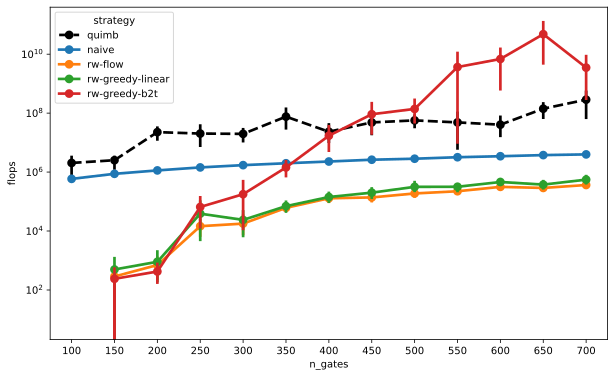

In [34]:
n_qubits = 10
n_gates_rng = range_repeat(100, 701, step=50, repeat=5)
circuits = [gen_random_CNOT_H_T_circuit(n_qubits, n_gates) for n_gates in n_gates_rng]
strategies = ['quimb', 'naive', 'rw-flow', 'rw-greedy-linear', 'rw-greedy-b2t']
sim_pointplot(circuits, strategies, 'n_gates', n_gates_rng, baseline='quimb', flops=True)

100%|██████████| 70/70 [25:03<00:00, 21.47s/it] 


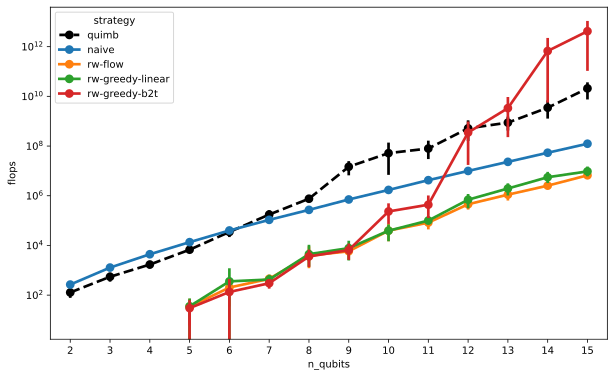

In [15]:
n_qubits_rng = range_repeat(2, 16, repeat=5)
n_gates_rng = [3 * n_qubits ** 2 for n_qubits in n_qubits_rng]
circuits = [gen_random_CNOT_H_T_circuit(n_qubits, n_gates) for n_qubits, n_gates in zip(n_qubits_rng, n_gates_rng)]
strategies = ['quimb', 'naive', 'rw-flow', 'rw-greedy-linear', 'rw-greedy-b2t']
sim_pointplot(circuits, strategies, 'n_qubits', n_qubits_rng, baseline='quimb', flops=True)

100%|██████████| 20/20 [00:54<00:00,  2.70s/it]


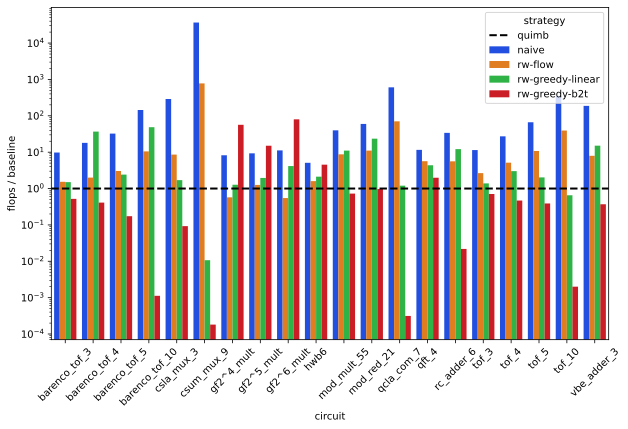

In [35]:
circuit_dir = '../circuits/qasm'
names = ['barenco_tof_3.qasm', 'barenco_tof_4.qasm', 'barenco_tof_5.qasm', 'barenco_tof_10.qasm', 'csla_mux_3.qasm',
         'csum_mux_9.qasm', 'gf2^4_mult.qasm', 'gf2^5_mult.qasm', 'gf2^6_mult.qasm', 'hwb6.qasm',
         'mod_mult_55.qasm', 'mod_red_21.qasm', 'qcla_com_7.qasm', 'qft_4.qasm', 'rc_adder_6.qasm',
         'tof_3.qasm', 'tof_4.qasm', 'tof_5.qasm', 'tof_10.qasm', 'vbe_adder_3.qasm']
circuits = list(read_structured_circuits(circuit_dir, names))
strategies = ['quimb', 'naive', 'rw-flow', 'rw-greedy-linear', 'rw-greedy-b2t']
names = [name.split('.')[0] for name in names]
sim_barplot(circuits, strategies, names, baseline='quimb', flops=True)

In [ ]:
circ = gen_toffoli(3)
g = circ.to_graph()
g.apply_state('0' * circ.qubits)
g.apply_effect('0' * circ.qubits)
zx.full_reduce(g)
with open('Benchmarks_tof_3_reduced_ZX.tikz', 'w') as f:
    f.write(g.to_tikz())

100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


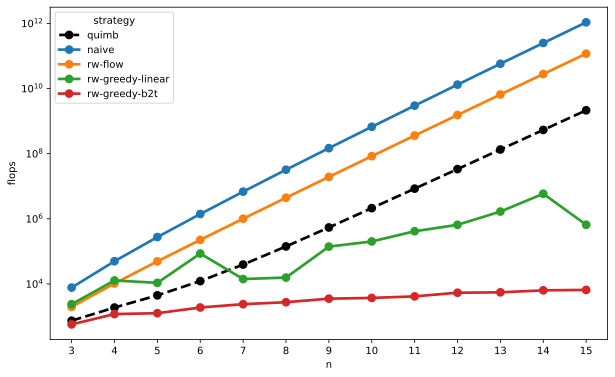

In [31]:
ns_rng = range_repeat(3, 16)
circuits = [gen_toffoli(n) for n in ns_rng]
strategies = ['quimb', 'naive', 'rw-flow', 'rw-greedy-linear', 'rw-greedy-b2t']
sim_pointplot(circuits, strategies, 'n', ns_rng, baseline='quimb', flops=True)

In [ ]:
from fractions import Fraction


def gen_random_ZX_diagram(n_vertices, p_edge):
    g = zx.Graph()
    for i in range(n_vertices):
        g.add_vertex(zx.VertexType.Z, phase=Fraction(1, 4))
    for i in range(n_vertices):
        for j in range(i):
            if np.random.binomial(1, p_edge):
                g.add_edge((i, j), zx.EdgeType.HADAMARD)
    return g

100%|██████████| 200/200 [21:53<00:00,  6.57s/it]


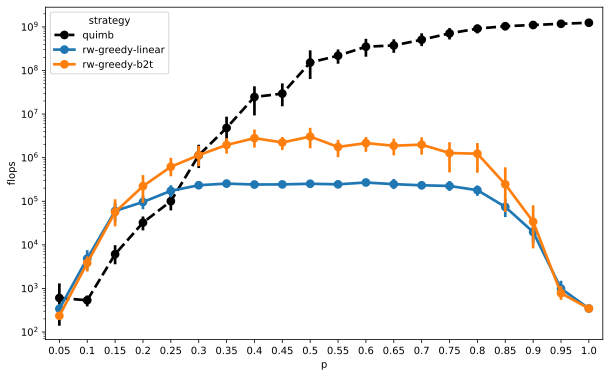

In [10]:
probs = [p / 100 for p in range_repeat(5, 101, step=5, repeat=10)]
graphs = [gen_random_ZX_diagram(30, p) for p in probs]
strategies = ['quimb', 'rw-greedy-linear', 'rw-greedy-b2t']
sim_pointplot(graphs, strategies, 'p', probs, baseline='quimb', flops=True)